# TEMA 3.3: K-Means and EMM

In this notebook, we will discuss different techniques for unsupervised learning and will focus on several clustering techniques. 

This first part of the notebook corresponds to Chapter 7 of the book **Introduction to Data Science, A Python Approch to Concepts, Techniques and Applications**, Laura Igual and Santi Seguí, Springer 2017 and Chapter 5 of the book **Python Data Science Handbook**, Jake VanderPlas, O’Reilly Media 2016


## Introduction to unsupervised learning

In machine learning, the problem of unsupervised learning is that of trying to **find hidden structure in unlabeled data**. Since the examples given to the learner are unlabeled, there is **no error or reward signal** to evaluate a potential solution. This distinguishes unsupervised learning from supervised learning. 

Unsupervised learning is defined as the set of algorithms which learns from a **training set of unlableled or unannotated** examples, using the features of the inputs to categorize them together according to some **geometric** or **statistical** criteria. 

Unsupervised learning encompasses many techniques that seek to **summarize and explain key features** of the data. Many methods employed in unsupervised learning are based on *data mining* methods used to preprocess data.

Different *kinds* of unsupervised learning problems:

+ *Clustering:* partition examples into groups when no pre-defined categories/classes are available.
+ *Dimensionality reduction:* principal component analysis, independent component analysis, non-negative matrix factorization.
+ *Outlier detection:* find unusual events (e.g. malfunction).
+ *Novelty detection:* find changes in data.

The most common unsupervised task is **clustering**. In this notebook, we will focus on the clustering.

<div class="alert alert-info"> **IMPORTANT IDEA: ** Clustering is subjective issue.
</div>

Clustering will help us to analyze and get insight of the data, but the quality of the partition **depends on the application and the analyst**.

## 1. K-means algorithm

**Algorithm:**
1. Initialize the value  $K$ of desirable clusters.
2. Initialize the $K$ cluster centers, e.g. randomly.
3. Decide the class memberships of the N data samples by assigning them to the nearest cluster centroids (e.g. the center of gravity or mean).
4. Re-estimate the $K$ cluster centers, by assuming the memberships found above are correct.
5. If none of the N objects changed membership in the last iteration, exit. Otherwise go to 3.

Let us see this in action:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

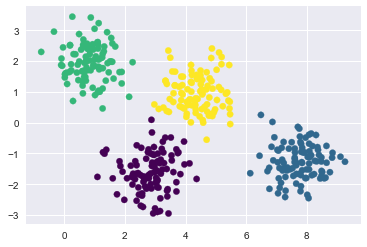

In [4]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');



From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assigment of points between them. Unfortunately, the k-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty). For this, we must think about generalizing the model.

One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster. We can visualize this cluster model with the following function:

In [5]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
    

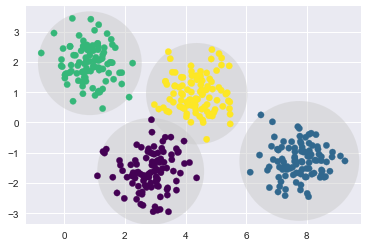

In [6]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

An important observation for k-means is that these cluster models must be circular: k-means has no built-in way of accounting for oblong or elliptical clusters. So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

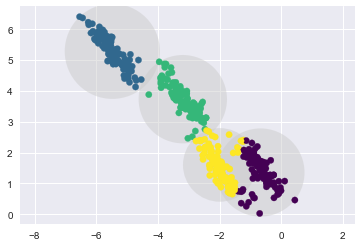

In [8]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

By eye, we recognize that these transformed clusters are non-circular, and thus circular clusters would be a poor fit. Nevertheless, k-means is not flexible enough to account for this, and tries to force-fit the data into three circular clusters. This results in a mixing of cluster assignments where the resulting circles overlap: see especially the top-left of this plot. 

In particular, the boundaries between k-means clusters will always be linear, which means that it will fail for more complicated boundaries. Consider the following data, along with the cluster labels found by the typical k-means approach:

In [9]:
from sklearn.datasets import make_moons
Xx, y = make_moons(200, noise=.05, random_state=0)

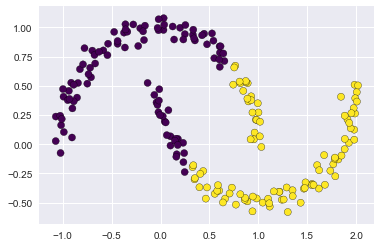

In [10]:
labels = KMeans(2, random_state=0).fit_predict(Xx)
plt.scatter(Xx[:, 0], Xx[:, 1], c=labels,
            s=50, cmap='viridis', edgecolors='k');

We can use a kernel transformation to project the data into a higher dimension where a linear separation is possible: this trick allows k-means to discover non-linear boundaries.

One version of this kernelized k-means is implemented in Scikit-Learn within the SpectralClustering estimator. It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a k-means algorithm:

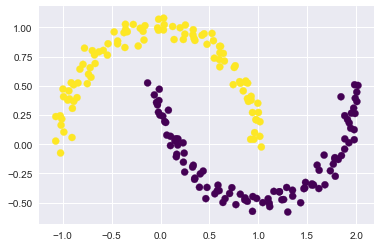

In [12]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(Xx)
plt.scatter(Xx[:, 0], Xx[:, 1], c=labels,
            s=50, cmap='viridis');

## 2. Generalizing E–M: Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means:

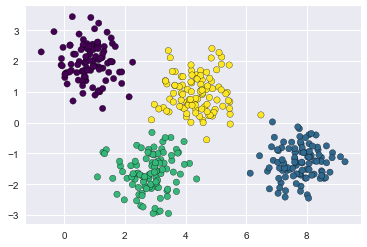

In [14]:
from sklearn.mixture import GMM

import warnings
warnings.filterwarnings("ignore")

gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, edgecolors='k', cmap='viridis');

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the predict_proba method. This returns a matrix of size [n_samples, n_clusters] which measures the probability that any point belongs to the given cluster:

In [15]:
probs = gmm.predict_proba(X)

print(X[:5])

print(probs[:5].round(3))


[[ 6.48826703  0.25006446]
 [ 2.52194722 -2.69798647]
 [ 3.06877291 -2.90007604]
 [ 4.31427482  0.70295058]
 [ 2.38449945 -2.53563494]]
[[0.    0.475 0.    0.525]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]]


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

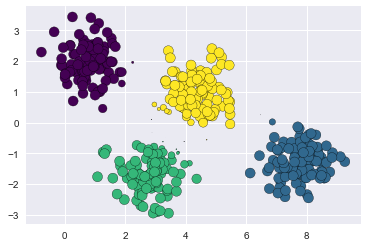

In [16]:
size = 100 * (probs.round(3).max(1)**100)  # square emphasizes differences

plt.scatter(X[:, 0], X[:, 1], c=labels, edgecolors='k', cmap='viridis', s=size);

Under the hood, a Gaussian mixture model is very similar to k-means: it uses an expectation–maximization approach which qualitatively does the following:

1. Choose starting guesses for the location and shape <br>
2. Repeat until converged:<br>
    A. E-step: for each point, find weights encoding the probability of membership in each cluster<br>
    B. M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights<br>
    
The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model. Just as in the k-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:

In [17]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

With this in place, we can take a look at what the four-component GMM gives us for our initial data:

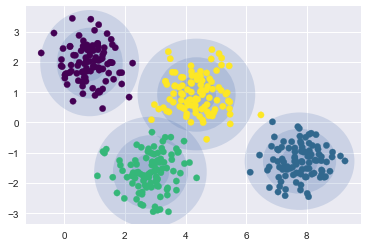

In [18]:
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)

Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

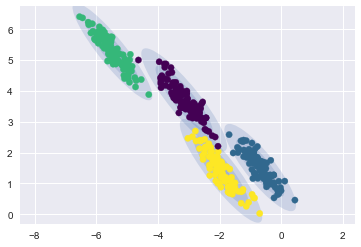

In [20]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

This makes clear that GMM addresses the two main practical issues with k-means encountered before.

## 3. GMM as Density Estimation

Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for density estimation. That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

As an example, consider some data generated from Scikit-Learn's make_moons function, which we saw in In Depth: K-Means Clustering:

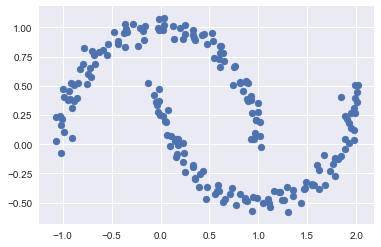

In [21]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);## Applying clustering to analyze countries according to their education resourses

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

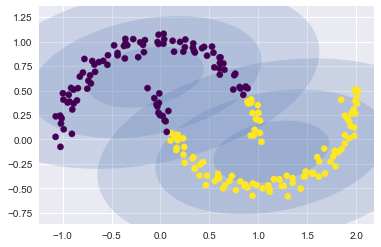

In [22]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

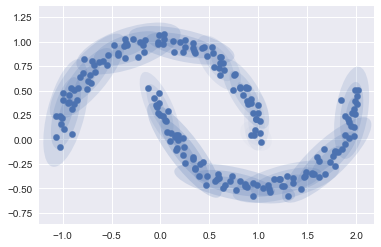

In [23]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall distribution of the input data. This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input. For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

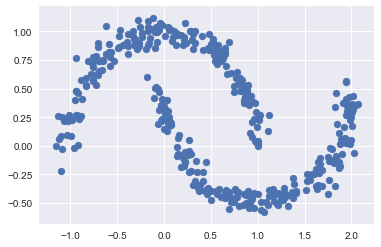

In [24]:
Xnew = gmm16.sample(400, random_state=42)
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.